In [6]:
!pip install torchattacks

In [7]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchattacks
import matplotlib.pyplot as plt
import numpy as np


In [8]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 test dataset
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Define test data loader
batch_size = 128
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified


In [9]:
# Load pre-trained VGG model
model = models.vgg16_bn(pretrained=True)
model.classifier[6] = torch.nn.Linear(4096, 100)  # Adjust for CIFAR-100 classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:11<00:00, 48.0MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Success Rate: 0.02109375


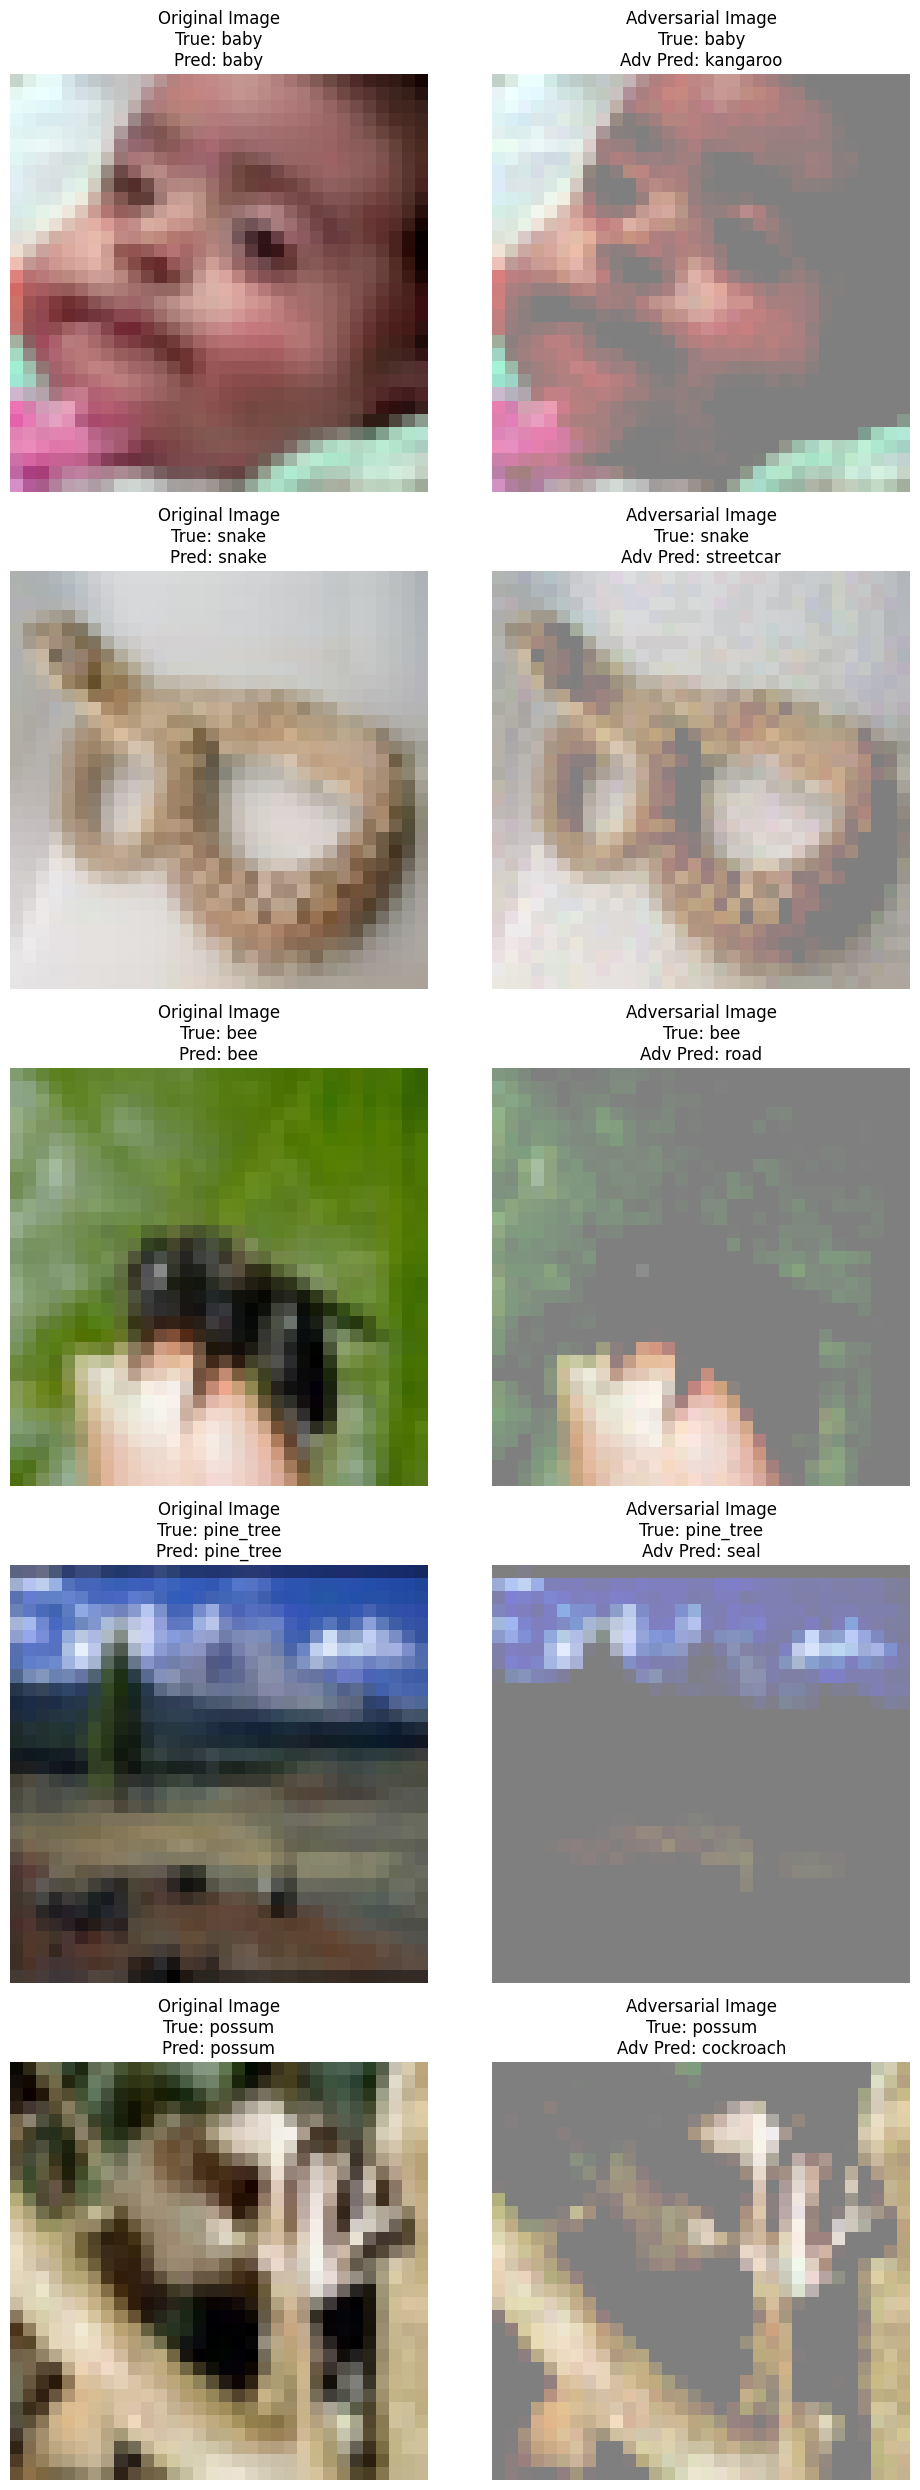

In [10]:
# FGSM Attack
attack_fgsm = torchattacks.FGSM(model, eps=8/255)

successful_attacks = 0
total_samples = 0
examples = []

torch.set_grad_enabled(True)
for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= 10:  # Limit to 10 batches for performance
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True

    adv_images = attack_fgsm(images, labels)
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples
print(f'Success Rate: {success_rate}')


# Visualization of some successful attack examples
if len(examples) > 0:
    num_examples_to_show = min(5, len(examples))
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {test_dataset.classes[true_label]}\nPred: {test_dataset.classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {test_dataset.classes[true_label]}\nAdv Pred: {test_dataset.classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful adversarial attacks were found.")


Success Rate: 0.02109375


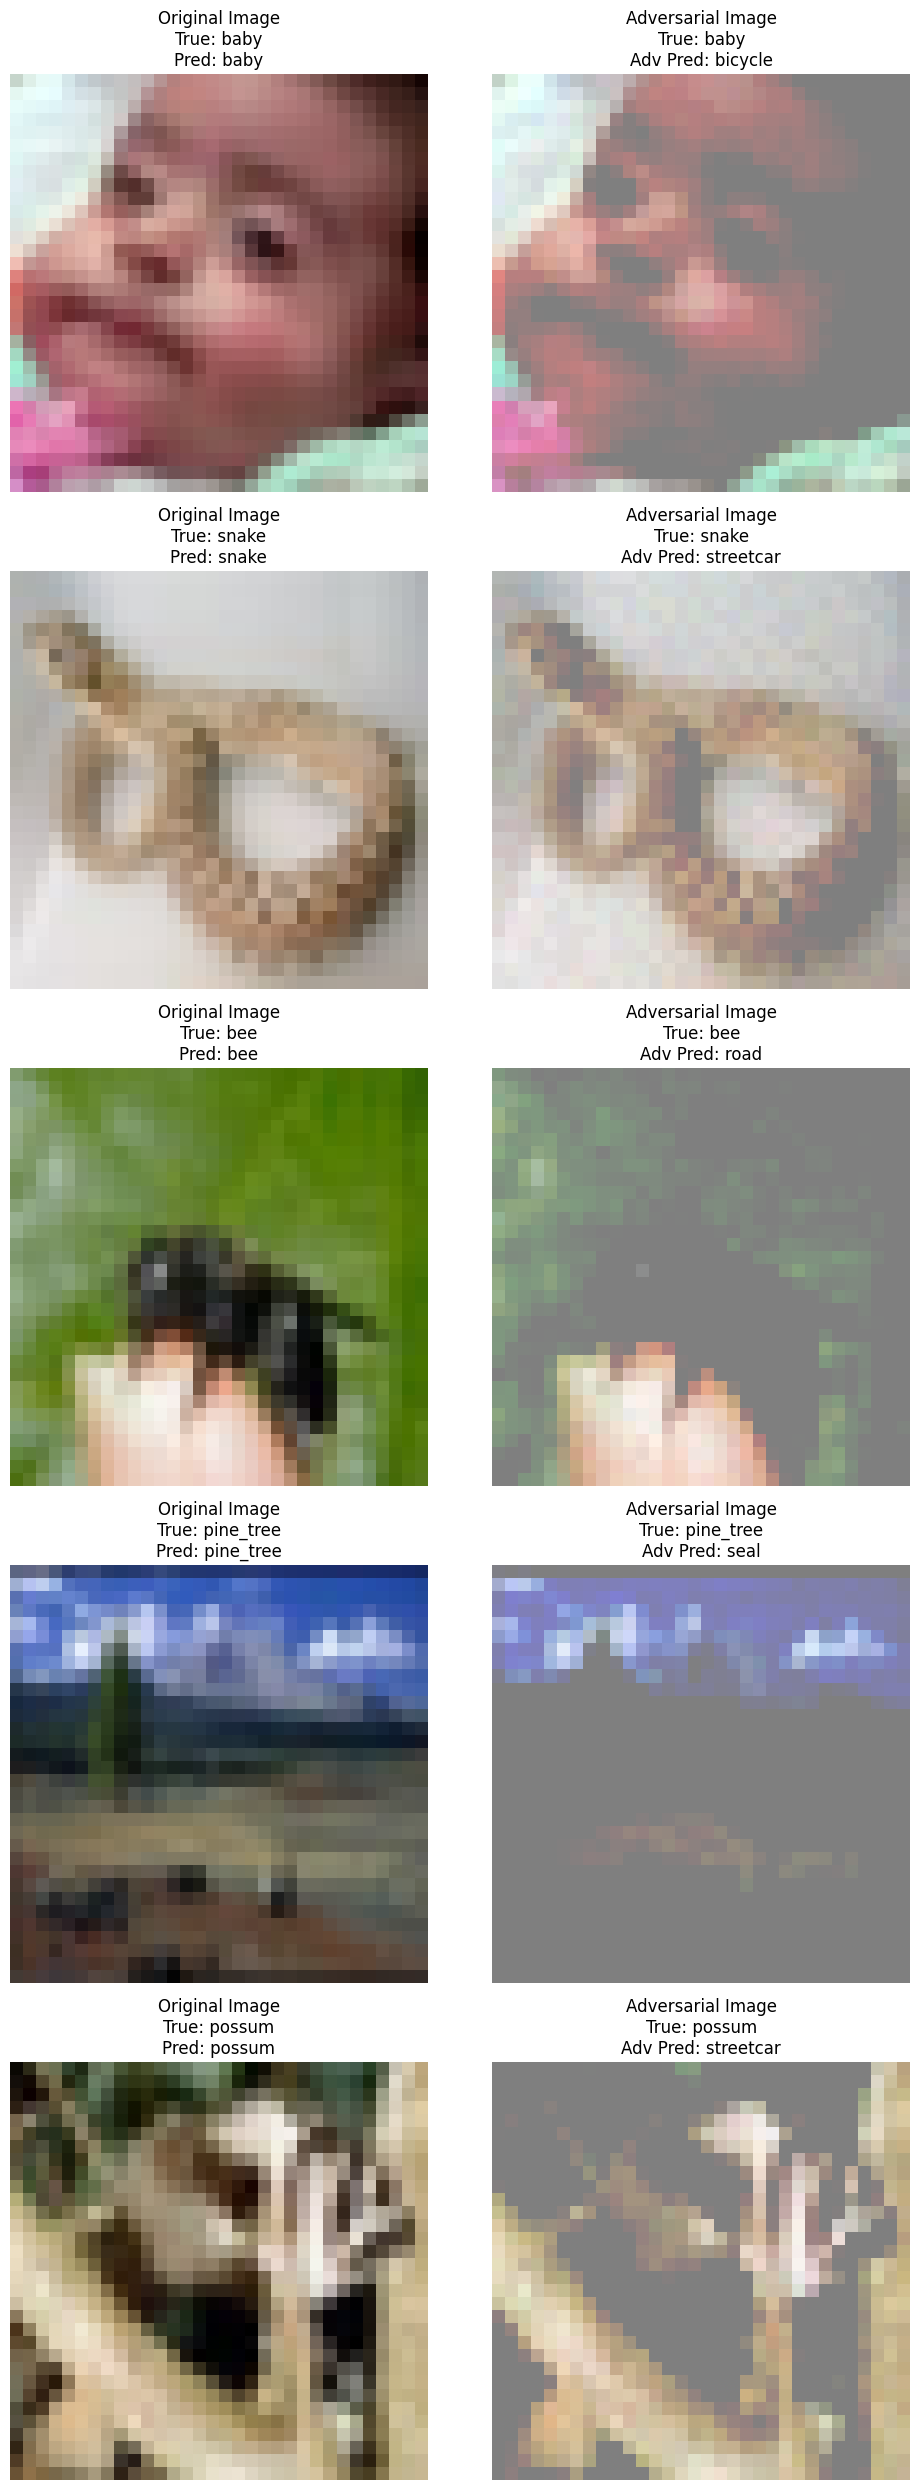

In [11]:
# FFGSM Attack
attack_ffgsm = torchattacks.FFGSM(model)

successful_attacks = 0
total_samples = 0
examples = []

torch.set_grad_enabled(True)
for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= 10:  # Limit to 10 batches for performance
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True

    adv_images = attack_ffgsm(images, labels)
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples
print(f'Success Rate: {success_rate}')


# Visualization of some successful attack examples
if len(examples) > 0:
    num_examples_to_show = min(5, len(examples))
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {test_dataset.classes[true_label]}\nPred: {test_dataset.classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {test_dataset.classes[true_label]}\nAdv Pred: {test_dataset.classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful adversarial attacks were found.")


Success Rate: 0.021875


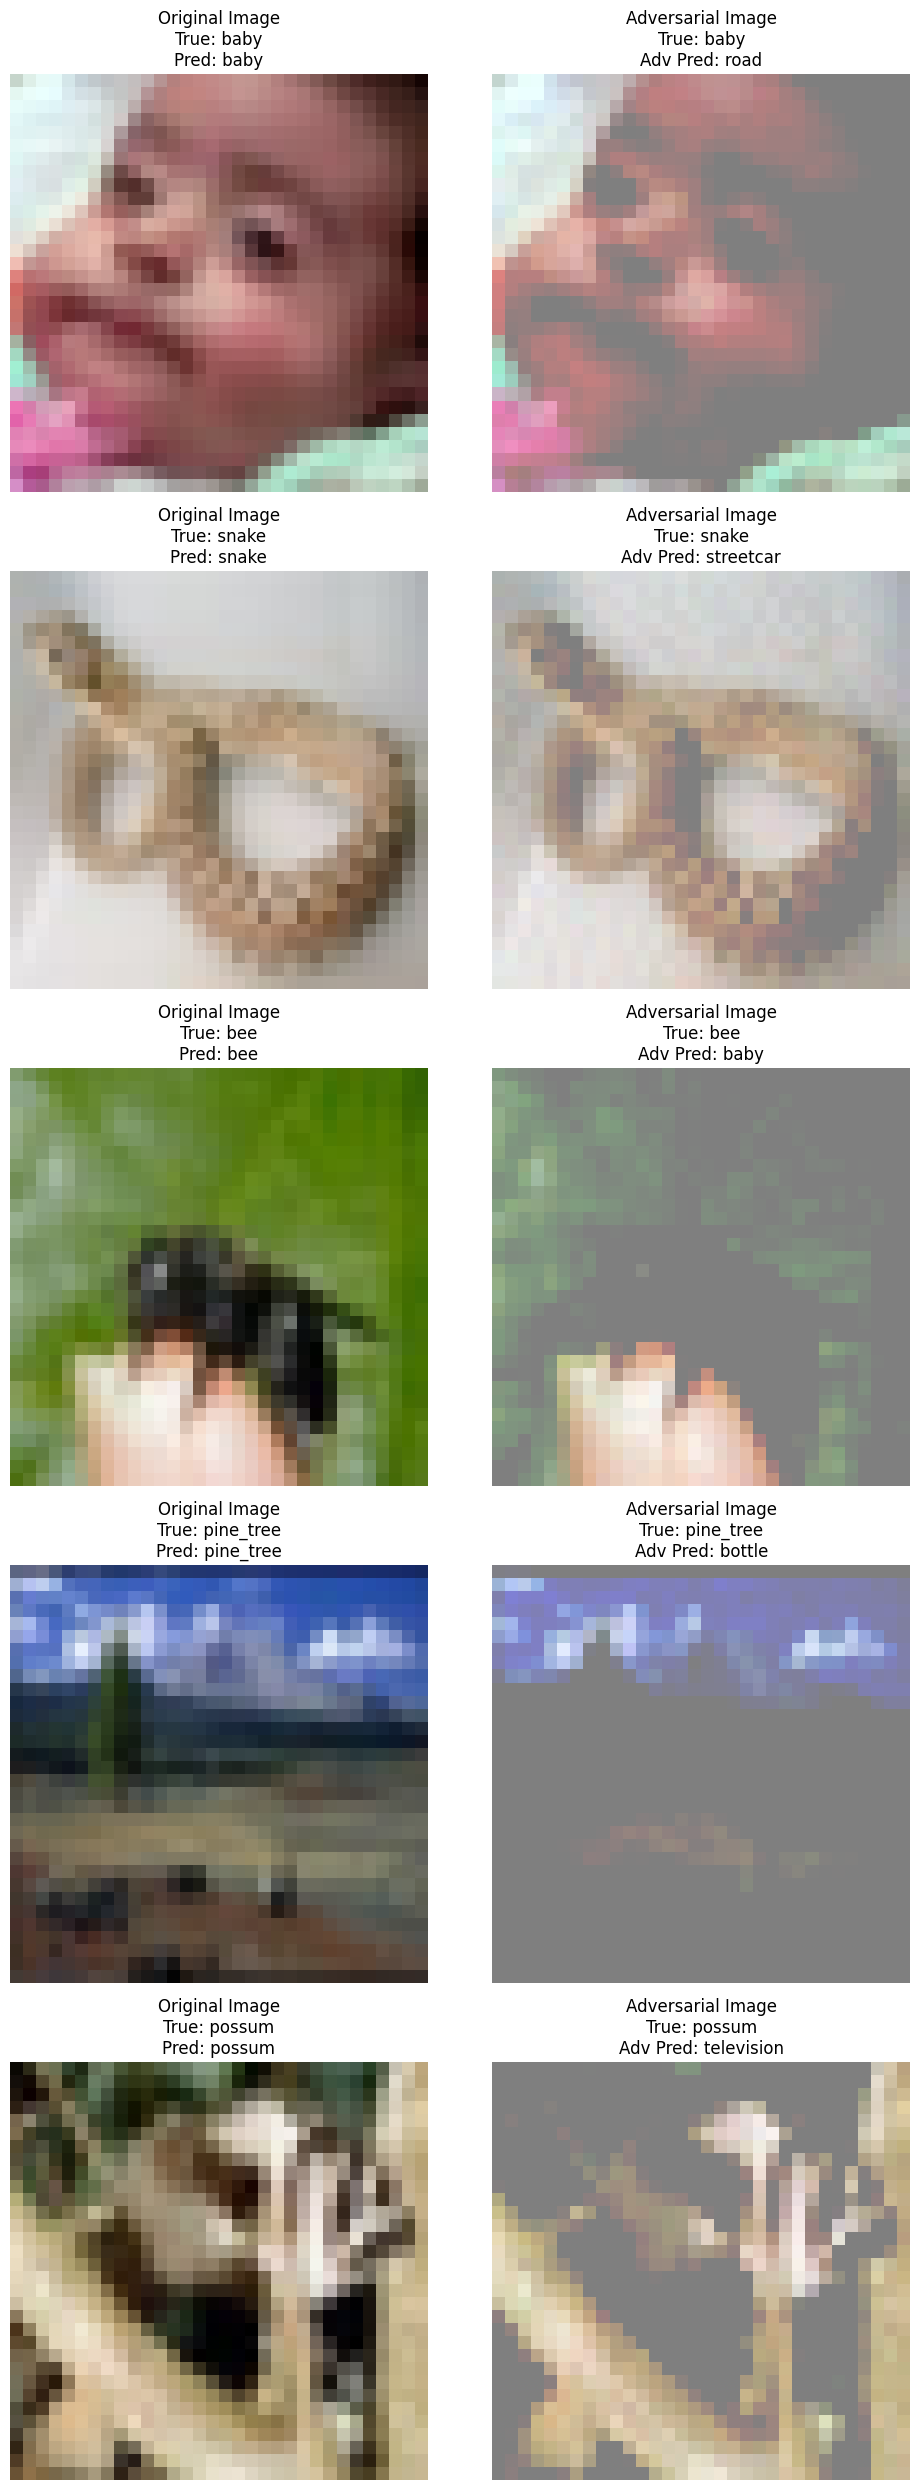

In [ ]:
# PGD Attack
attack_pgd = torchattacks.PGD(model)

successful_attacks = 0
total_samples = 0
examples = []

torch.set_grad_enabled(True)
for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= 10:  # Limit to 10 batches for performance
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True

    adv_images = attack_pgd(images, labels)
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples
print(f'Success Rate: {success_rate}')


# Visualization of some successful attack examples
if len(examples) > 0:
    num_examples_to_show = min(5, len(examples))
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {test_dataset.classes[true_label]}\nPred: {test_dataset.classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {test_dataset.classes[true_label]}\nAdv Pred: {test_dataset.classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful adversarial attacks were found.")


Success Rate: 0.021875


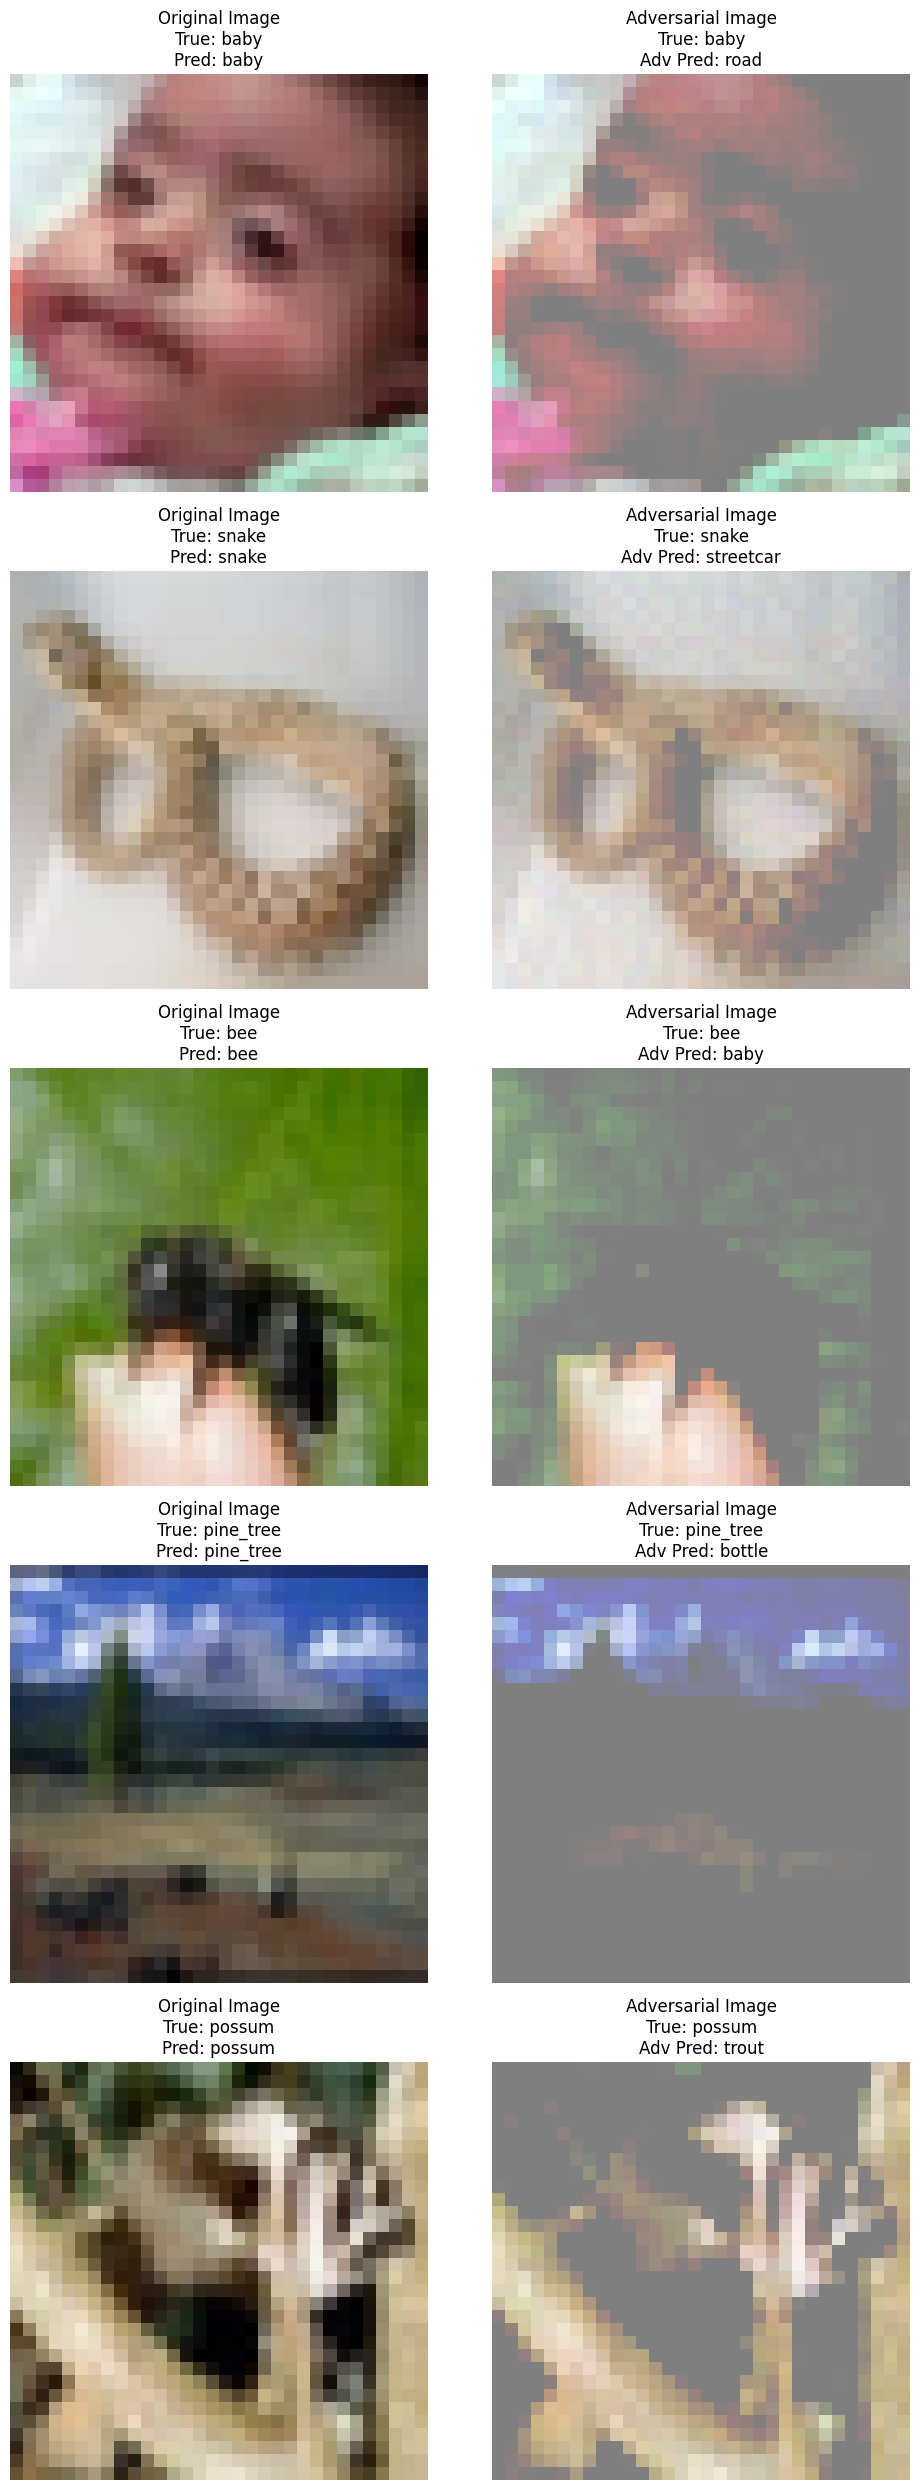

In [ ]:
# EOTPGD Attack
attack_eotpgd = torchattacks.EOTPGD(model)

successful_attacks = 0
total_samples = 0
examples = []

torch.set_grad_enabled(True)
for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= 10:  # Limit to 10 batches for performance
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True

    adv_images = attack_eotpgd(images, labels)
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples
print(f'Success Rate: {success_rate}')


# Visualization of some successful attack examples
if len(examples) > 0:
    num_examples_to_show = min(5, len(examples))
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {test_dataset.classes[true_label]}\nPred: {test_dataset.classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {test_dataset.classes[true_label]}\nAdv Pred: {test_dataset.classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful adversarial attacks were found.")


Success Rate: 0.021875


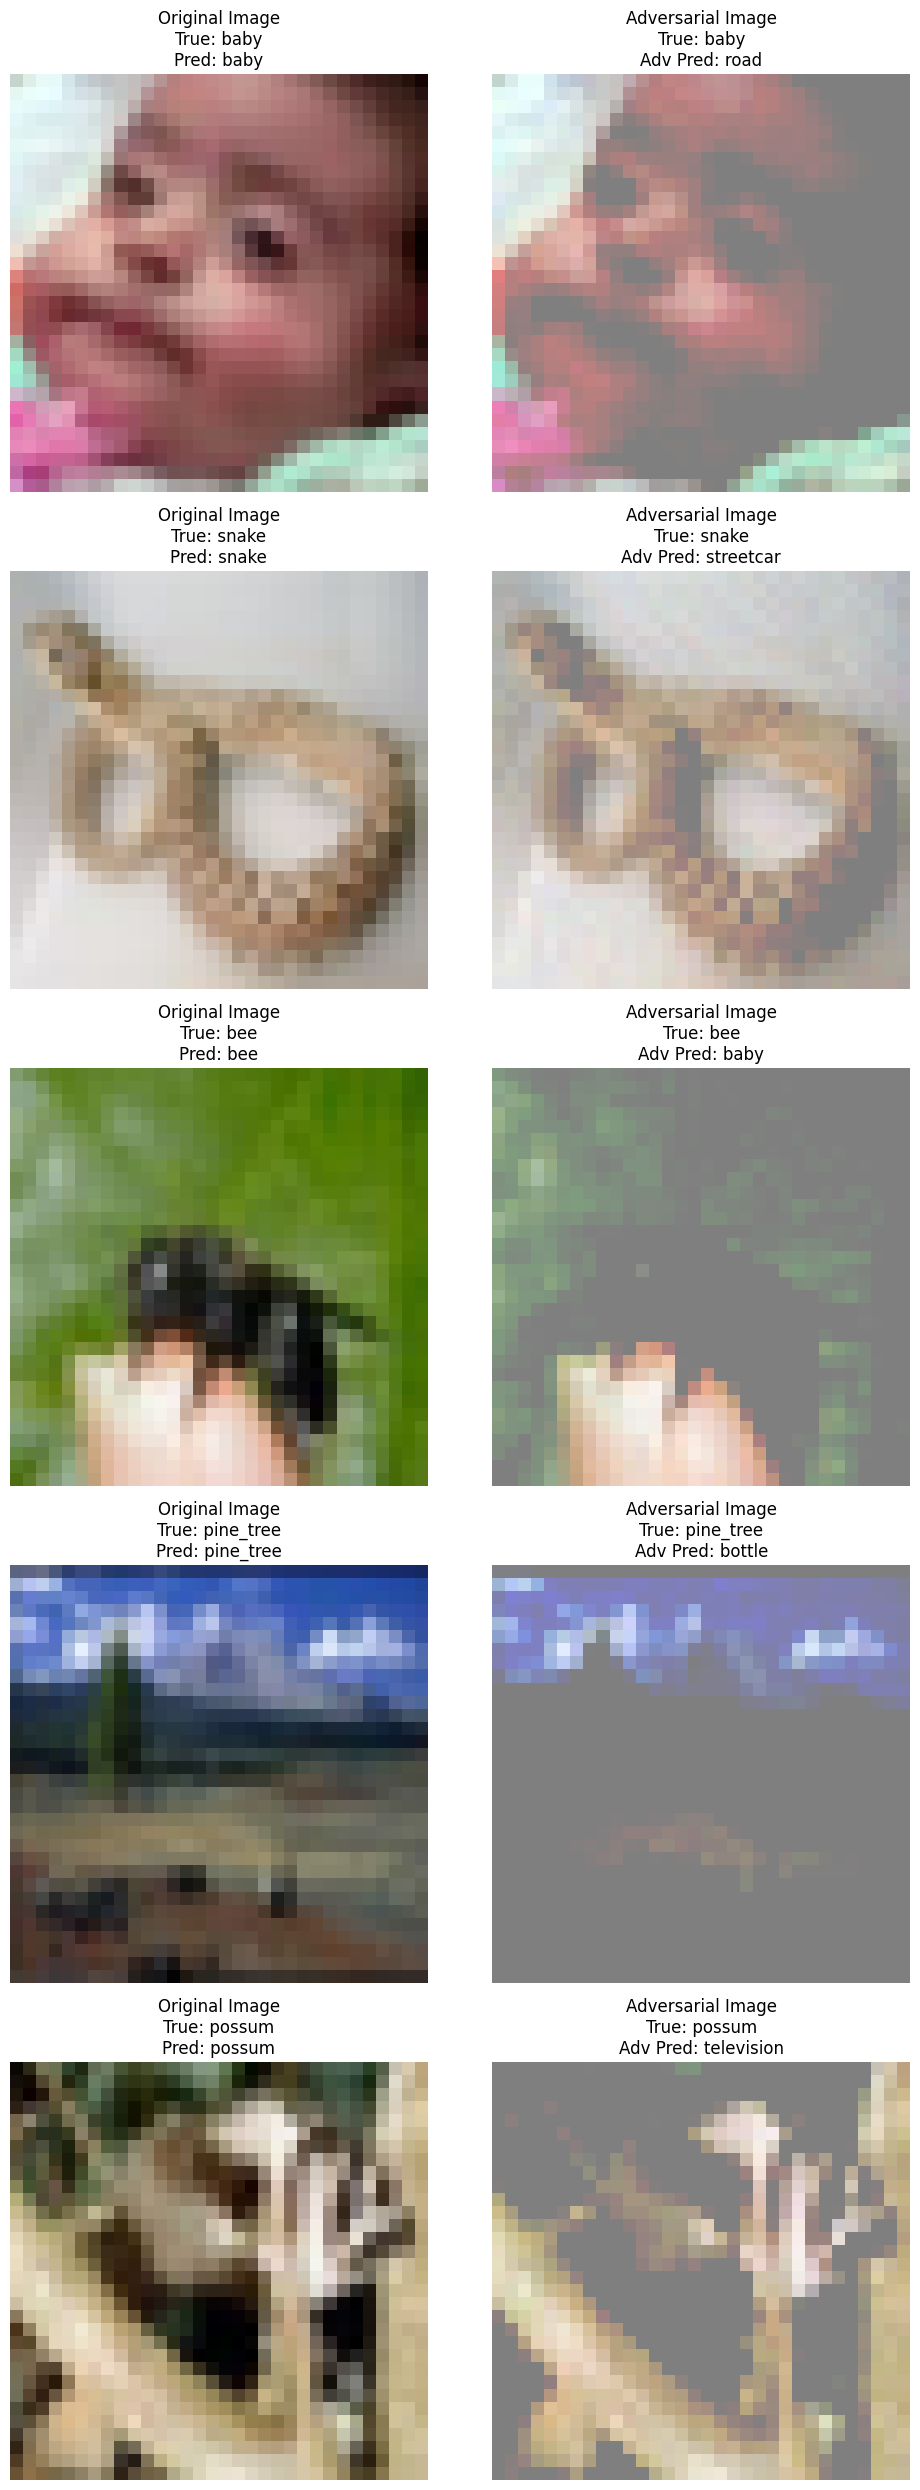

In [ ]:
# RFGSM Attack
attack_rfgsm = torchattacks.RFGSM(model)

successful_attacks = 0
total_samples = 0
examples = []

torch.set_grad_enabled(True)
for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= 10:  # Limit to 10 batches for performance
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True

    adv_images = attack_rfgsm(images, labels)
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples
print(f'Success Rate: {success_rate}')


# Visualization of some successful attack examples
if len(examples) > 0:
    num_examples_to_show = min(5, len(examples))
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {test_dataset.classes[true_label]}\nPred: {test_dataset.classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {test_dataset.classes[true_label]}\nAdv Pred: {test_dataset.classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful adversarial attacks were found.")


In [ ]:
# FAB Attack
attack_fab = torchattacks.FAB(model)

successful_attacks = 0
total_samples = 0
examples = []

torch.set_grad_enabled(True)
for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= 10:  # Limit to 10 batches for performance
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True

    adv_images = attack_fab(images, labels)
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples
print(f'Success Rate: {success_rate}')


# Visualization of some successful attack examples
if len(examples) > 0:
    num_examples_to_show = min(5, len(examples))
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {test_dataset.classes[true_label]}\nPred: {test_dataset.classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {test_dataset.classes[true_label]}\nAdv Pred: {test_dataset.classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful adversarial attacks were found.")